## Background
Previously, I modeled a "heat box", but ignored the effects of the sun. As anyone who has had to get into a car that has sat outside for a while on a hot summer day, the inside of the car is warmer than the outside air temperature, and my previous model didn't allow that. So the sun is important.  Consider the following information from [The Humane Society](https://www.humanesociety.org/resources/what-do-if-you-see-pet-parked-car).

> It doesn't have to be that warm outside for a car to become dangerously hot inside.
>
> - When it's 72 degrees Fahrenheit outside, the temperature inside your car can heat up to 116 degrees Fahrenheit within an hour.
> - When it's 80 degrees Fahrenheit outside, the temperature inside your car can heat up to 99 degrees Fahrenheit within 10 minutes.
> - Rolling down the windows has been shown to have little effect on the temperature inside a car.

Let's translate these temperatures to Celsius and Kelvin

- When it's 22 degrees Celsius (295 K) outside, the temperature inside your car can heat up to 47 degrees Celsius (320 K) within an hour.
- When it's 27 degrees Celsius (300 K) outside, the temperature inside your car can heat up to 37 degrees Celsius (310 K) within 10 minutes.

My plan for this post is to assume that my heat box will heat up similarly to the above generic car, and see what sort of parameters I need to make that work.

## Previous work
As before, I'll model the system as a simple box, however, this time it will be car-sized, and I'll use thermal properties that are common for metals like aluminum

In [1]:
import numpy as np

# Heat parameters
thermalDiffusivity = 22.39e-6 # meters^2/s for air
heatTransferCoef = 1 # For a typical metal to air W/m^2K
thermalConductivity = 50 # For a typical metal W/mK
specificHeat = 1000 # for aluminum J/kg K
wallDensity = 3000 # kg/m^3 for aluminum
wallThickness = 0.002 # m
solarIntensity = 1000 # W/m^2

# Length parameters (meters)
L = 3
W = 2
H = 1.5

Deltax = 0.05
xmax = int(L/Deltax)
ymax = int(W/Deltax)
zmax = int(H/Deltax)

xmid = xmax // 2
ymid = ymax // 2
zmid = zmax // 2

xgrid = np.linspace(0,L,xmax+1)
ygrid = np.linspace(0,W,ymax+1)
zgrid = np.linspace(0,H,zmax+1)

u0 = np.empty((xmax,ymax,zmax))

## Heat Equation
The heat equation is:

$$
\frac{\partial u}{\partial t} = \alpha \nabla^2u + \text{Internal Power Generation Term} + \text{Convection on the boundary}
$$

Where $\alpha=\frac{k}{c\rho}$ is the thermal diffusivity of the material, and $k$ is the thermal conductivity, $c$ is the specific heat, and $\rho$ is the density.

When working numerically, it is common to employ a finite mesh and determine the system temperature at discrete points in space as follows
$$
u(x,y,z,t) \rightarrow u(x_i,y_j,z_k,t) = u_{ijk}(t)
$$

### Internal Power Generation
This should be proportional to the solar intensity.  For now, I will model it as:

$$
A I_{\text{sun}} f(x,y,z)
$$

where $A$ is a constant that I will determine empirically. For this model, I will assume:

$$
f(x,y,z) = 
\begin{cases}
1 &z=H \\
0 &\text{else}
\end{cases}
$$

This has the meaning that for this model, the sun is directly overhead

In [2]:
def powerGen(umat, intensity, A):
    powerGen = np.zeros_like(umat)

    powerDensity = A*intensity
    powerGen[:,:,-1].fill(powerDensity)

    return powerGen

### Boundary convection

The power exchange per unit volume due to convection is proportional to the difference in temperature of air and the temperature at the boundary:

$$
B \left(T_{\text{air}}-u(x_S,y_S,z_S,t)\right)
$$
for points $(x_S,y_S,z_S)$ on the boundary of the object (assuming a uniform air temperature). Again, $B$ is a constant that I will determine empirically.


In [3]:
def bdryConv(umat, Tair, B):

    bdryTemp = np.zeros_like(umat)
    uSurf = np.zeros_like(umat)

    bdryTemp[0,:,:].fill(Tair)
    bdryTemp[:,0,:].fill(Tair)
    bdryTemp[:,:,0].fill(Tair)
    bdryTemp[-1,:,:].fill(Tair)
    bdryTemp[:,-1,:].fill(Tair)
    bdryTemp[:,:,-1].fill(Tair)

    uSurf[0,:,:] = umat[0,:,:]
    uSurf[:,0,:] = umat[:,0,:]
    uSurf[:,:,0] = umat[:,:,0]
    uSurf[-1,:,:] = umat[-1,:,:]
    uSurf[:,-1,:] = umat[:,-1,:]
    uSurf[:,:,-1] = umat[:,:,-1]

    duConvdt = B*(bdryTemp - uSurf)
    return duConvdt    

### Laplacian 

The Laplacian using the finite element analysis is:

\begin{align*}
\nabla^2 u(x,y,z,t) &\rightarrow \frac{1}{\Delta x\Delta y\Delta z} \left(\Delta y \Delta z \frac{u_{i-1,j,k}(t) + u_{i+1,j,k}(t) - 2 u_{i,j,k}(t)}{\Delta x} 
            + \Delta x \Delta z \frac{u_{i,j-1,k}(t) + u_{i,j+1,k}(t) - 2 u_{i,j,k}(t)}{\Delta y} 
            + \Delta x \Delta y \frac{u_{i,j,k-1}(t) + u_{i,j,k+1}(t) - 2 u_{i,j,k}(t)}{\Delta z}\right) \\
            &= \frac{u_{i-1,j,k}(t) + u_{i+1,j,k}(t) - 2 u_{i,j,k}(t)}{\Delta x^2} 
            + \frac{u_{i,j-1,k}(t) + u_{i,j+1,k}(t) - 2 u_{i,j,k}(t)}{\Delta y^2} 
            + \frac{u_{i,j,k-1}(t) + u_{i,j,k+1}(t) - 2 u_{i,j,k}(t)}{\Delta z^2}
\end{align*}

If we generate our grid with $\Delta x = \Delta y = \Delta z$, we obtain:

$$
\nabla^2 u_{i,j,k}(t) = \frac{u_{i-1,j,k}(t) + u_{i+1,j,k}(t) + u_{i,j-1,k}(t) + u_{i,j+1,k}(t) + u_{i,j,k-1}(t) + u_{i,j,k+1}(t) - 6 u_{i,j,k}(t)}{\Delta x^2}
$$

In [4]:
def lap3DFE(umat,dx):
    lap = np.empty_like(umat)

    # Interior elements:
    lap[1:-1,1:-1,1:-1] = (umat[:-2, 1:-1, 1:-1] + umat[2:, 1:-1, 1:-1] + umat[1:-1, :-2, 1:-1] + 
                           umat[1:-1, 2:, 1:-1] + umat[1:-1,1:-1,:-2] + umat[1:-1,1:-1,2:] - 6*umat[1:-1,1:-1,1:-1]) / dx**2

    # Surface elements:
    lap[0,1:-1,1:-1] = (2* umat[1, 1:-1, 1:-1] + 
                        umat[0, :-2, 1:-1] + umat[0, 2:, 1:-1] + umat[0, 1:-1, :-2] + umat[0, 1:-1, 2:] - 6*umat[0, 1:-1, 1:-1]) / (2*dx**2)
    lap[-1,1:-1,1:-1] = (2* umat[-2, 1:-1, 1:-1] + 
                        umat[-1, :-2, 1:-1] + umat[-1, 2:, 1:-1] + umat[-1, 1:-1, :-2] + umat[-1, 1:-1, 2:] - 6*umat[-1, 1:-1, 1:-1]) / (2*dx**2)
    lap[1:-1,0,1:-1] = (2* umat[1:-1, 1, 1:-1] + 
                        umat[:-2, 0, 1:-1] + umat[2:, 0, 1:-1] + umat[1:-1, 0, :-2] + umat[1:-1, 0, 2:] - 6*umat[1:-1, 0, 1:-1]) / (2*dx**2)
    lap[1:-1,-1,1:-1] = (2* umat[1:-1, -2, 1:-1] + 
                        umat[:-2, -1, 1:-1] + umat[2:, -1, 1:-1] + umat[1:-1, -1, :-2] + umat[1:-1, -1, 2:] - 6*umat[1:-1, -1, 1:-1]) / (2*dx**2)
    lap[1:-1,1:-1,0] = (2* umat[1:-1, 1:-1, 1] + 
                        umat[:-2, 1:-1, 0] + umat[2:, 1:-1, 0] + umat[1:-1, :-2, 0] + umat[1:-1, 2:, 0] - 6*umat[1:-1, 1:-1, 0]) / (2*dx**2)
    lap[1:-1,1:-1,-1] = (2* umat[1:-1, 1:-1, -2] + 
                        umat[:-2, 1:-1, -1] + umat[2:, 1:-1, -1] + umat[1:-1, :-2, -1] + umat[1:-1, 2:, -1] - 6*umat[1:-1, 1:-1, -1]) / (2*dx**2)

    # Edge Elements:
    lap[0,0,1:-1] = (2 * umat[1, 0, 1:-1] + 2 * umat[0, 1, 1:-1] + umat[0, 0, :-2] + umat[0, 0, 2:] - 6*umat[0, 0, 1:-1]) / (4*dx**2)
    lap[0,-1,1:-1] = (2 * umat[1, -1, 1:-1] + 2 * umat[0, -2, 1:-1] + umat[0, -1, :-2] + umat[0, -1, 2:] - 6*umat[0, -1, 1:-1]) / (4*dx**2)
    lap[-1,0,1:-1] = (2 * umat[2, 0, 1:-1] + 2 * umat[-1, 1, 1:-1] + umat[-1, 0, :-2] + umat[-1, 0, 2:] - 6*umat[-1, 0, 1:-1]) / (4*dx**2)
    lap[-1,-1,1:-1] = (2 * umat[2, -1, 1:-1] + 2 * umat[-1, -2, 1:-1] + umat[-1, -1, :-2] + umat[-1, -1, 2:] - 6*umat[-1, -1, 1:-1]) / (4*dx**2)
    lap[0,1:-1,0] = (2 * umat[1, 1:-1, 0] + 2 * umat[0, 1:-1, 1] + umat[0, 2:, 0] + umat[0, :-2, 0] - 6*umat[0, 1:-1, 0]) / (4*dx**2)
    lap[0,1:-1,-1] = (2 * umat[1, 1:-1, -1] + 2 * umat[0, 1:-1, -2] + umat[0, 2:, -1] + umat[0, :-2, -1] - 6*umat[0, 1:-1, -1]) / (4*dx**2)
    lap[-1,1:-1,0] = (2 * umat[-2, 1:-1, 0] + 2 * umat[-1, 1:-1, 1] + umat[-1, 2:, 0] + umat[-1, :-2, 0] - 6*umat[-1, 1:-1, 0]) / (4*dx**2)
    lap[-1,1:-1,-1] = (2 * umat[-2, 1:-1, -1] + 2 * umat[-1, 1:-1, -2] + umat[-1, 2:, -1] + umat[-1, :-2, -1] - 6*umat[-1, 1:-1, -1]) / (4*dx**2)
    lap[1:-1,0,0] = (2 * umat[1:-1, 1, 0] + 2 * umat[1:-1, 0, 1] + umat[:-2, 0, 0] + umat[2:, 0, 0] - 6*umat[1:-1, 0, 0]) / (4*dx**2)
    lap[1:-1,0,-1] = (2 * umat[1:-1, 1, -1] + 2 * umat[1:-1, 0, -2] + umat[:-2, 0, -1] + umat[2:, 0, -1] - 6*umat[1:-1, 0, -1]) / (4*dx**2)
    lap[1:-1,-1,0] = (2 * umat[1:-1, -2, 0] + 2 * umat[1:-1, -1, 1] + umat[:-2, -1, 0] + umat[2:, -1, 0] - 6*umat[1:-1, -1, 0]) / (4*dx**2)
    lap[1:-1,-1,-1] = (2 * umat[1:-1, 2, -1] + 2 * umat[1:-1, -1, -2] + umat[:-2, -1, -1] + umat[2:, -1, -1] - 6*umat[1:-1, -1, -1]) / (4*dx**2)    
    
    # Corner Elements:
    lap[0,0,0] = (umat[1, 0, 0] + umat[0, 1, 0] + umat[0, 0, 1] - 3*umat[0, 0, 0]) / (2*dx**2)
    lap[-1,0,0] = (umat[-2, 0, 0] + umat[-1, 1, 0] + umat[-1, 0, 1] - 3*umat[-1, 0, 0]) / (2*dx**2)
    lap[0,-1,0] = (umat[1, -1, 0] + umat[0, -2, 0] + umat[0, -1, 1] - 3*umat[0, -1, 0]) / (2*dx**2)
    lap[0,0,-1] = (umat[1, 0, -1] + umat[0, 1, -1] + umat[0, 0, -2] - 3*umat[0, 0, -1]) / (2*dx**2)
    lap[0,-1,-1] = (umat[1, -1, -1] + umat[0, -2, -1] + umat[0, -1, -2] - 3*umat[0, -1, -1]) / (2*dx**2)
    lap[-1,0,-1] = (umat[-2, 0, -1] + umat[-1, 1, -1] + umat[-1, 0, -2] - 3*umat[-1, 0, -1]) / (2*dx**2)
    lap[-1,-1,0] = (umat[2, -1, 0] + umat[-1, -2, 0] + umat[-1, -1, 1] - 3*umat[-1, -1, 0]) / (2*dx**2)
    lap[-1,-1,-1] = (umat[-2, -1, -1] + umat[-1, -2, -1] + umat[-1, -1, -2] - 3*umat[-1, -1, -1]) / (2*dx**2)

    return lap

In [5]:
def dudt(t,u, alpha, intensity, dx, Tair, A, B):
    dudt = alpha*lap3DFE(u,dx) + powerGen(u,intensity, A) + bdryConv(u, Tair, B)
    return dudt

I will have to flatten things as `solve_ivp` only solves a vector system of equations rather than the higher dimenionality matrix system that I've created.

In [6]:
def dudtFlat(t,uflat, alpha, intensity, dx, Tair, A, B):
    u = uflat.reshape(xmax,ymax,zmax)
    return dudt(t,u, alpha, intensity, dx, Tair, A, B).flatten()

## One hour calculation

In [7]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

def simToyHotBox(A,B,tmax,nt):
    print("Simulating the system")
    airTemp = 27
    eqTemp = airTemp + A*solarIntensity/B * L*W/(2*(L*W + L*H + W*H))
    u0.fill(airTemp)
    time = np.arange(0,tmax,nt)
    
    tenHourCalc = solve_ivp(dudtFlat, t_span=[0,10*oneHour], y0=u0.flatten(), t_eval= time, 
                            args=[thermalDiffusivity,solarIntensity,Deltax,airTemp,A,B])

    print("Simulation complete")
    return tenHourCalc

oneHour = 3600
# Best parameters from previous simulation
A = 1.1176e-3
B = 6.6667e-3
longCalc = simToyHotBox(A,B,oneHour*10, 100)    
shortCalc = simToyHotBox(A,B,oneHour/10, 10)


Simulating the system
Simulation complete
Simulating the system
Simulation complete


## Surface Plot

Now I'll make a surface plot based on [this example](https://matplotlib.org/stable/gallery/mplot3d/box3d.html#sphx-glr-gallery-mplot3d-box3d-py). 

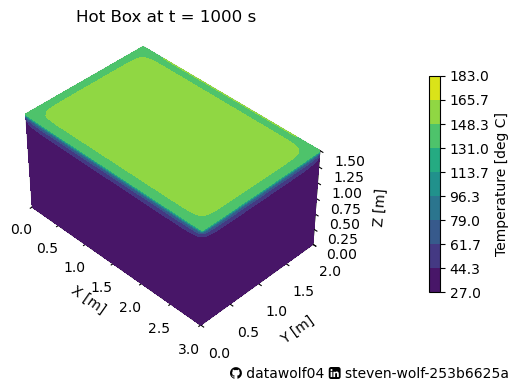

In [8]:
def hotBoxSurfPlot(res,l):
    theTime = res.t[l]
    uflat = res.y[:, l]
    xm, ym, zm = u0.shape
    umat = uflat.reshape((xm,ym,zm))
    Y,X,Z = np.meshgrid(np.linspace(0,W,ym),np.linspace(0,L,xm),np.linspace(0,H,zm))

    kw = {
        'vmin': res.y.min(),
        'vmax': res.y.max(),
        'levels': np.linspace(res.y.min(),res.y.max(), 10),
    }

    theTitle = f'Hot Box at t = {theTime:.0f} s'

    # Create figure with 3D axes
    fig = plt.figure(figsize=(7,4))
    ax = fig.add_subplot(111, projection='3d')
    
    ax.set_title(theTitle)
    # Plot contour surfaces
    _ = ax.contourf(X[:, :, -1], Y[:, :, -1], umat[:, :, -1],
                    zdir='z', offset=H, **kw
                   )
    _ = ax.contourf(X[:, 0, :], umat[:, 0, :], Z[:, 0, :],
                    zdir='y', offset=0, **kw
                   )
    C = ax.contourf(umat[-1, :, :], Y[-1, :, :], Z[-1, :, :],
                    zdir='x', offset=L, **kw
                   )
    # --

    # Set limits of the plot from coord limits
    xmin, xmax = 0, L
    ymin, ymax = 0, W
    zmin, zmax = 0, H
    ax.set(xlim=[xmin, xmax], ylim=[ymin, ymax], zlim=[zmin, zmax])

    # Set labels 
    ax.set(
        xlabel='X [m]',
        ylabel='Y [m]',
        zlabel='Z [m]',
    )

    # Set zoom and angle view
    ax.view_init(40, -45, 0)
    ax.set_box_aspect((xm,ym,zm), zoom=1)

    # Colorbar
    fig.colorbar(C, ax=ax, fraction=0.02, pad=0.2, label='Temperature [deg C]')
    ghLogo = u"\uf09b"
    liLogo = u"\uf08c"
    txt = f"{ghLogo} datawolf04 {liLogo} steven-wolf-253b6625a"
    plt.figtext(0.6,0.01, txt,family=['DejaVu Sans','FontAwesome'],fontsize=10)
    return fig, ax

hotBoxSurfPlot(longCalc,10)
plt.show()


Make the surface plot differently

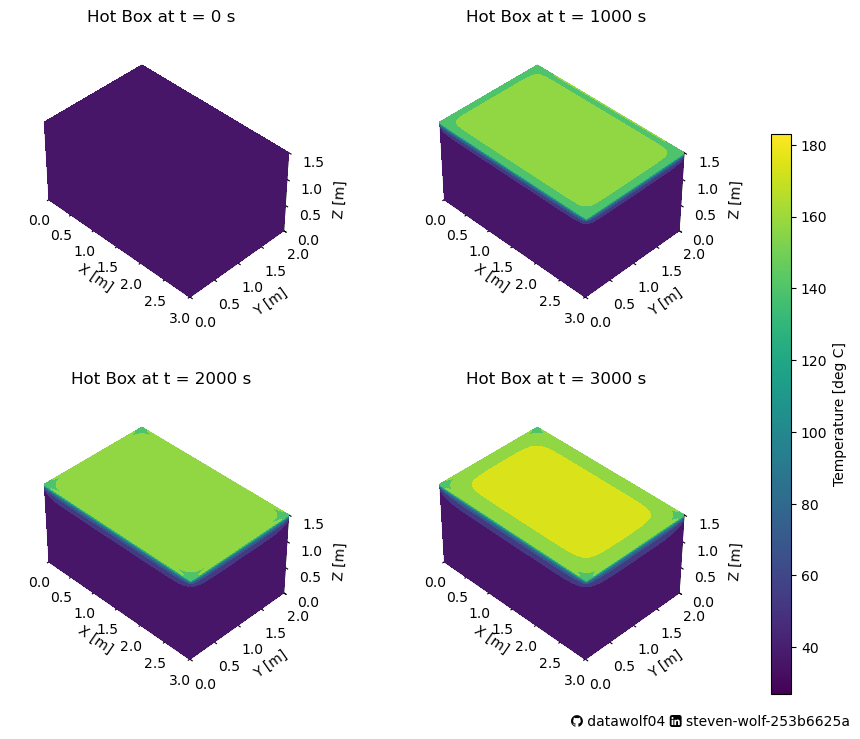

In [9]:
import matplotlib.colors as mc
import matplotlib.cm as cm

timeIdx = [0, 10, 20, 30]
xm, ym, zm = u0.shape
Y,X,Z = np.meshgrid(np.linspace(0,W,ym),np.linspace(0,L,xm),np.linspace(0,H,zm))
 
kw = {
    'vmin': longCalc.y.min(),
    'vmax': longCalc.y.max(),
    'levels': np.linspace(longCalc.y.min(),longCalc.y.max(), 10),
}

cnorm = mc.Normalize(vmin=longCalc.y.min(),vmax=longCalc.y.max())
cbar = cm.ScalarMappable(norm=cnorm)

# Set limits of the plot from coord limits
xmin, xmax = 0, L
ymin, ymax = 0, W
zmin, zmax = 0, H
xt = np.arange(0,L+0.5,0.5)
yt = np.arange(0,W+0.5,0.5)
zt = np.arange(0,H+0.5,0.5)

i = 0
fig = plt.figure(figsize=(10,8))
cellList = [221,222,223,224]
for cell in cellList:
    l = timeIdx[i]
    theTime = longCalc.t[l]
    theTitle = f'Hot Box at t = {theTime:.0f} s'
    umatFlat = longCalc.y[:,l]
    umat = umatFlat.reshape((xm,ym,zm))
    ax = fig.add_subplot(cell, projection='3d')
    # Set title, limits, and labels
    ax.set_title(theTitle)
    ax.set(xlim=[xmin, xmax], ylim=[ymin, ymax], zlim=[zmin, zmax],xlabel='X [m]',ylabel='Y [m]',zlabel='Z [m]',
          xticks=xt,yticks=yt,zticks=zt)
    # Set zoom and angle view
    ax.view_init(40, -45, 0)
    ax.set_box_aspect((xm,ym,zm), zoom=0.85)
    ax.contourf(X[:, :, -1], Y[:, :, -1], umat[:, :, -1],
                    zdir='z', offset=H, **kw)
    ax.contourf(X[:, 0, :], umat[:, 0, :], Z[:, 0, :],
                    zdir='y', offset=0, **kw)
    ax.contourf(umat[-1, :, :], Y[-1, :, :], Z[-1, :, :],
                    zdir='x', offset=L, **kw)
    i += 1

ghLogo = u"\uf09b"
liLogo = u"\uf08c"
txt = f"{ghLogo} datawolf04 {liLogo} steven-wolf-253b6625a"
fig.subplots_adjust(bottom=0.05,right=0.85)
plt.figtext(0.7,0.01, txt,family=['DejaVu Sans','FontAwesome'],fontsize=10)
cbar_ax = fig.add_axes([0.9, 0.05, 0.02, 0.7])
fig.colorbar(cbar, cax=cbar_ax,label='Temperature [deg C]')
plt.show()

Let's animate this plot using [matplotlib](https://matplotlib.org/stable/users/explain/animations/animations.html).

In [30]:
import matplotlib.pyplot as plt
import fontawesome as fa
import matplotlib.colors as mc
import matplotlib.cm as cm
import matplotlib.animation as animation

def makeAni(fname,res,L,W,H,dx):
    print("Building the animation")
    # Create figure with 3D axes
    fig = plt.figure(figsize=(6,4))
    ax = fig.add_subplot(111, projection='3d')
    # Fill in the plot
    theTime = res.t[0]
    tmax = len(res.t)
    theTitle = f'Hot Box at t = {theTime:.0f} s'
    figTitle = fig.suptitle(theTitle)

    xm, ym, zm = int(L/dx), int(W/dx), int(H/dx)
    uflat = res.y[:,0]
    umat = uflat.reshape((xm,ym,zm))
    Y,X,Z = np.meshgrid(np.linspace(0,W,ym),np.linspace(0,L,xm),np.linspace(0,H,zm))

    kw = {
        'vmin': res.y.min(),
        'vmax': res.y.max(),
        'levels': np.linspace(res.y.min(),res.y.max(), 10),
    }
    cnorm = mc.Normalize(vmin=res.y.min(),vmax=res.y.max())
    cbar = cm.ScalarMappable(norm=cnorm)
    
    # Plot contour surfaces
    topSurf = ax.contourf(X[:, :, -1], Y[:, :, -1], umat[:, :, -1], zdir='z', offset=H, **kw)
    frontSurf = ax.contourf(X[:, 0, :], umat[:, 0, :], Z[:, 0, :], zdir='y', offset=0, **kw)
    leftSurf = ax.contourf(umat[-1, :, :], Y[-1, :, :], Z[-1, :, :], zdir='x', offset=L, **kw)
    # --

    # Set limits of the plot from coord limits
    xmin, xmax = 0, L
    ymin, ymax = 0, W
    zmin, zmax = 0, H
    ax.set(xlim=[xmin, xmax], ylim=[ymin, ymax], zlim=[zmin, zmax])

    # Set labels 
    ax.set(
        xlabel='X [m]',
        ylabel='Y [m]',
        zlabel='Z [m]',
        xticks = np.arange(0,L+0.5,0.5),
        yticks = np.arange(0,W+0.5,0.5),
        zticks = np.arange(0,H+0.5,0.5),
    )

    # Set zoom and angle view
    ax.view_init(40, -45, 0)
    ax.set_box_aspect((xm,ym,zm), zoom=1)

    # Colorbar
    fig.subplots_adjust(left=-1.75,bottom=0.2,right=0.9)
    fig.colorbar(cbar, ax=ax, fraction=0.02, pad=0.075, label='Temperature [deg C]')
    ghLogo = u"\uf09b"
    liLogo = u"\uf08c"
    txt = f"{ghLogo} datawolf04 {liLogo} steven-wolf-253b6625a"
    plt.figtext(0.5,0.01, txt,family=['DejaVu Sans','FontAwesome'],fontsize=10)

    def update(l):
        if (l+1)%10==0:
            print(f"Frame {l+1} out of {tmax} complete.")
        uflat = res.y[:,l]
        umat = uflat.reshape((xm,ym,zm))
        theTime = res.t[l]
        theTitle = f'Hot Box at t = {theTime:.0f} s'
        figTitle = fig.suptitle(theTitle)
        topSurf = ax.contourf(X[:, :, -1], Y[:, :, -1], umat[:, :, -1], zdir='z', offset=H, **kw)
        frontSurf = ax.contourf(X[:, 0, :], umat[:, 0, :], Z[:, 0, :], zdir='y', offset=0, **kw)
        leftSurf = ax.contourf(umat[-1, :, :], Y[-1, :, :], Z[-1, :, :], zdir='x', offset=L, **kw)

        return topSurf, frontSurf, leftSurf, figTitle

    ani = animation.FuncAnimation(fig=fig, func=update, frames=tmax, interval=50, repeat=False)
    ani.save(fname,writer='pillow')    

makeAni('hotboxShort.gif', shortCalc,L,W,H,Deltax)

Building the animation


/tmp/ipykernel_211380/152857513.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(6,4))


Frame 10 out of 36 complete.
Frame 20 out of 36 complete.
Frame 30 out of 36 complete.
